# Titanic Analysis & Prediction

In [2]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t as tdist
import scipy.stats as stats
import pylab
import re
import sklearn
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
import tensorflow as tf

## Exploration & Feature Selection

In [3]:
train = pd.read_csv('csv/train.csv')
test = pd.read_csv('csv/test.csv')
PassengerId = test['PassengerId']
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
print train.isnull().sum()
print test.isnull().sum()
print test.info()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usa

We should also see who survived and who didn't, as well as visualize the data

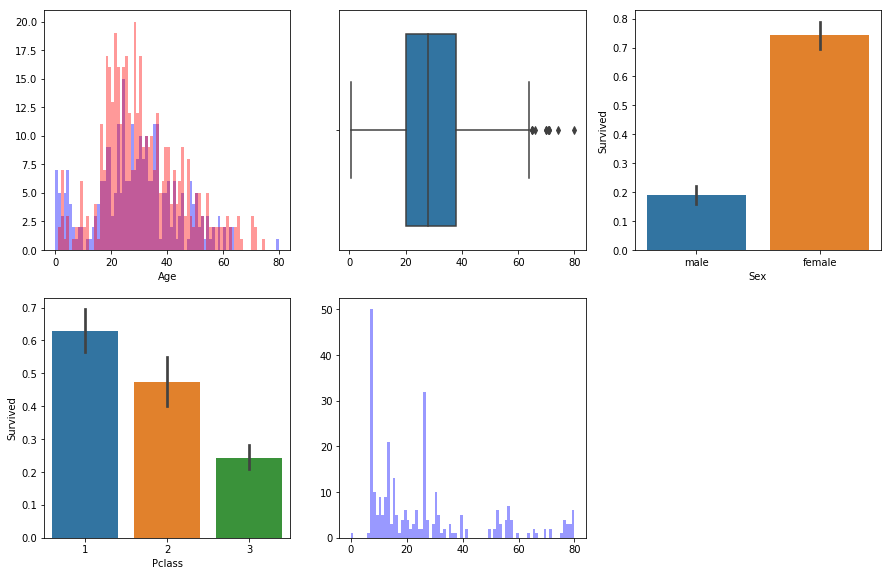

In [7]:
surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]
surv_col = "blue"
nosurv_col = "red"
fig = plt.figure()
plt.figure(figsize=[15,15])
plt.subplot(331)
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='Age')
plt.subplot(332)
sns.boxplot(x=train["Age"].dropna().values)
plt.subplot(333)
sns.barplot('Sex', 'Survived', data=train)
plt.subplot(334)
sns.barplot('Pclass', 'Survived', data=train)
plt.subplot(335)
sns.distplot(surv['Fare'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)

''

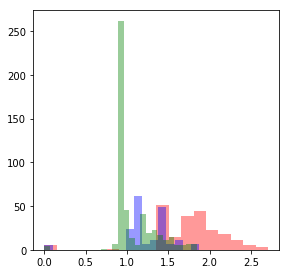

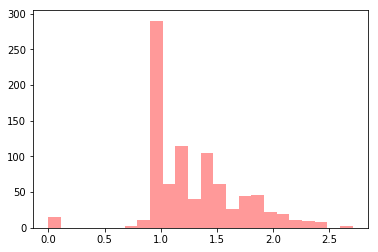

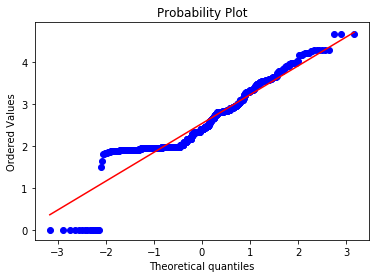

In [8]:
grouped = list(train.groupby(['Pclass']))
s = grouped[0][1]
fig = plt.figure()
plt.figure(figsize=[15,15])
plt.subplot(331)
sns.distplot(np.log10(grouped[0][1]['Fare'].dropna().values+1),kde=False, color="red")
sns.distplot(np.log10(grouped[1][1]['Fare'].dropna().values+1),kde=False, color="blue")
sns.distplot(np.log10(grouped[2][1]['Fare'].dropna().values+1),kde=False, color="green")

#pd.qcut(train["Fare"].dropna().values,4)
fig = plt.figure()
sns.distplot(np.log10(train["Fare"].dropna().values+1),kde=False, color="red")


fig = plt.figure()
transformed = stats.boxcox(np.asfarray(train["Fare"].dropna().values+1))[0]
stats.probplot(transformed, dist="norm", plot=pylab)
;

/home/shyam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


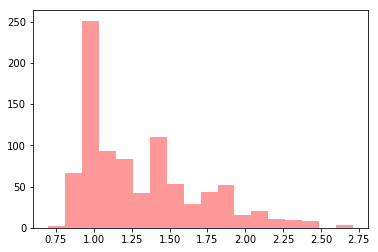

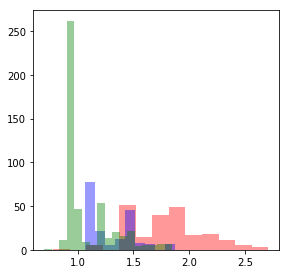

In [9]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(transformed.reshape(-1,1))
train["Fare"][np.where(kmeans.labels_ == 2)[0]] = np.median(train["Fare"])
fig = plt.figure()
sns.distplot(np.log10(train["Fare"].dropna().values+1),kde=False, color="red")
grouped = list(train.groupby(['Pclass']))
fig = plt.figure()
plt.figure(figsize=[15,15])
plt.subplot(331)
sns.distplot(np.log10(grouped[0][1]['Fare'].dropna().values+1),kde=False, color="red")
sns.distplot(np.log10(grouped[1][1]['Fare'].dropna().values+1),kde=False, color="blue")
sns.distplot(np.log10(grouped[2][1]['Fare'].dropna().values+1),kde=False, color="green")

In [10]:
# print np.mean(grouped[0][1]["Fare"])
# print np.mean(grouped[1][1]["Fare"])
# print np.mean(grouped[2][1]["Fare"])
values, quantiles = pd.qcut(train['Fare'], 3,retbins=True,labels=False)
quantiles
train['Fare'] = values
train["Fare"] = train["Fare"].astype('category')
values, quantiles = pd.qcut(test['Fare'], 3,retbins=True,labels=False)
test['Fare'] = values
test["Fare"] = train["Fare"].astype('category')

In [496]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,0,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,2,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,0,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,0,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,0,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,2,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,1,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,1,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,2,NaN,S


In [11]:
train['Cabin'].str[0].value_counts()
def CabinKnown(df):
    cabin = df["Cabin"]
    cabin = cabin.fillna(0)
    cabin.loc[cabin != 0] = 1
    df["CabinKnown"] = cabin
    df['Cabin'] = (df['Cabin'].str[0]).fillna(value='H')
    return df
train = CabinKnown(train)
test = CabinKnown(test)
test.head(10)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinKnown
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,0,H,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,2,H,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,0,H,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2,H,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,0,H,S,0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,0,H,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,2,H,Q,0
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,1,H,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,1,H,C,0
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,2,H,S,0


In [12]:
print(train[train['Embarked'].isnull()])

x = list(train.loc[(train['Embarked'] !='Q') & (train['Fare'] == 2) & (train['Sex'] == "female")].groupby(['Embarked','Pclass','Sex','Parch','SibSp']))
    #(train['Sex'] == "female")).groupby(['Embarked','Pclass','Sex','Parch','SibSp']).size()
print x[0][1].shape[0]
print x[1][1].shape[0]
print x[2][1].shape[0]
train['Embarked'].iloc[61] = "C"
train['Embarked'].iloc[829] = "C"

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket Fare Cabin Embarked CabinKnown  
61   female  38.0      0      0  113572    2     B      NaN          1  
829  female  62.0      0      0  113572    2     B      NaN          1  
18
15
4


/home/shyam/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Next, we'll deal with the various ages. We'll check whether the values are approximately normal to determine imputation. We can see that they are somewhat normal except for the edges, so we can pick a random value between the mean +- 3*std

/home/shyam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


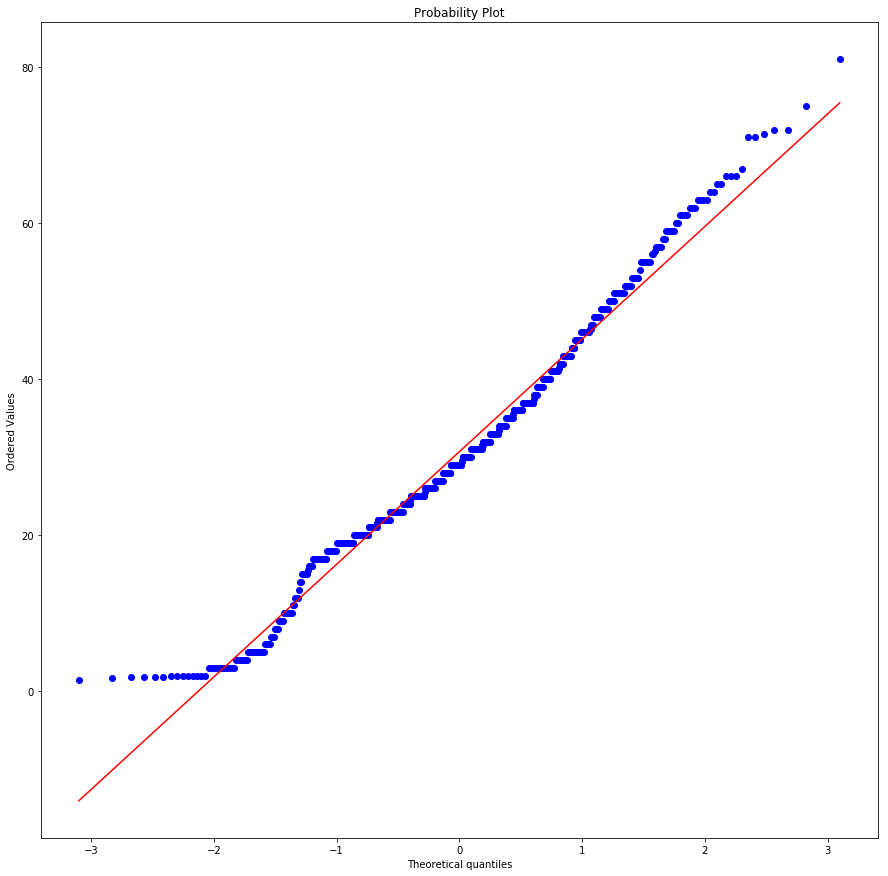

In [13]:
fig = plt.figure()
plt.figure(figsize=[15,15])
stats.probplot(train["Age"].dropna().values+1, dist="norm", plot=pylab)
;
full_data = [train,test]
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - 3*age_std, age_avg + 3*age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

#stats.probplot(ages, dist="norm", plot=pylab)


''

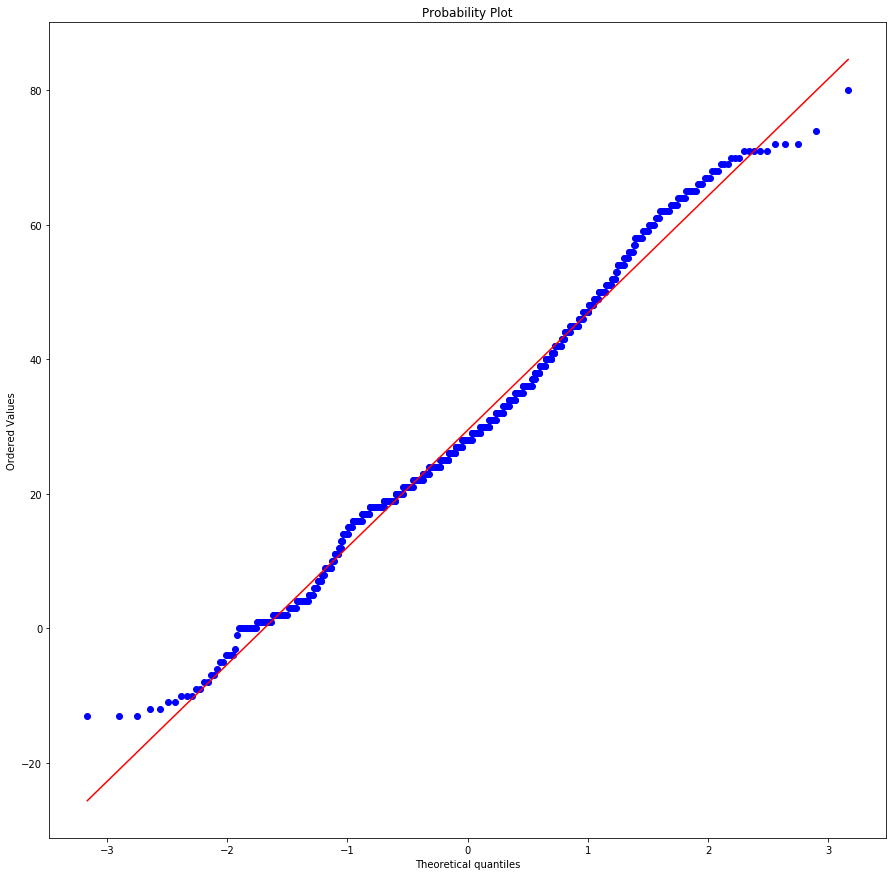

In [14]:
fig = plt.figure()
plt.figure(figsize=[15,15])
stats.probplot(train["Age"], dist="norm", plot=pylab)
;

In [15]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
def removenames(dataset):
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    return dataset
train = removenames(train)
test = removenames(test)

In [16]:
train['Family'] = train['SibSp'] + train['Parch']
test['Family'] = test['SibSp'] + test['Parch']
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinKnown,Title,Family
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,0,H,S,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,2,C,C,1,3,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,0,H,S,0,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,2,C,S,1,3,1
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,0,H,S,0,1,0
5,6,0,3,"Moran, Mr. James",1,47,0,0,330877,0,H,Q,0,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",1,54,0,0,17463,2,E,S,1,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2,3,1,349909,1,H,S,0,4,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27,0,2,347742,1,H,S,0,3,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14,1,0,237736,2,H,C,0,3,1


In [17]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Parch','SibSp']
train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)

train.head(10)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,CabinKnown,Title,Family
0,0,3,1,22,0,H,S,0,1,1
1,1,1,0,38,2,C,C,1,3,1
2,1,3,0,26,0,H,S,0,2,0
3,1,1,0,35,2,C,S,1,3,1
4,0,3,1,35,0,H,S,0,1,0
5,0,3,1,47,0,H,Q,0,1,0
6,0,1,1,54,2,E,S,1,1,0
7,0,3,1,2,1,H,S,0,4,4
8,1,3,0,27,1,H,S,0,3,2
9,1,2,0,14,2,H,C,0,3,1


In [13]:
train.head(10)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,CabinKnown,Title,Family
0,0,3,1,22,0,H,S,0,1,1
1,1,1,0,38,2,C,C,1,3,1
2,1,3,0,26,0,H,S,0,2,0
3,1,1,0,35,2,C,S,1,3,1
4,0,3,1,35,0,H,S,0,1,0
5,0,3,1,31,0,H,Q,0,1,0
6,0,1,1,54,2,E,S,1,1,0
7,0,3,1,2,1,H,S,0,4,4
8,1,3,0,27,1,H,S,0,3,2
9,1,2,0,14,2,H,C,0,3,1


## Now we prepare for modelling

In [18]:
test.head(10)
test["Cabin"].value_counts()
train["Cabin"].loc[train["Cabin"] == 'T'] = 'H'
train["Cabin"].value_counts()

H    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Cabin, dtype: int64

In [19]:
train.head(10)

def clean(data):
    data["Sex"] = data["Sex"].astype("int")
    data["Embarked"] = data["Embarked"].astype("category")
    data["Embarked"].cat.categories = [0,1,2]
    data["Embarked"] = data["Embarked"].astype("int")
    data["Cabin"] = data["Cabin"].astype("category")
    data["Cabin"].cat.categories = [0,1,2,3,4,5,6,7]
    data["Cabin"] = data["Cabin"].astype("int")
    return data
train = clean(train)
test = clean(test)

In [20]:
train.head(10)
#test.head(10)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,CabinKnown,Title,Family
0,0,3,1,22,0,7,2,0,1,1
1,1,1,0,38,2,2,0,1,3,1
2,1,3,0,26,0,7,2,0,2,0
3,1,1,0,35,2,2,2,1,3,1
4,0,3,1,35,0,7,2,0,1,0
5,0,3,1,47,0,7,1,0,1,0
6,0,1,1,54,2,4,2,1,1,0
7,0,3,1,2,1,7,2,0,4,4
8,1,3,0,27,1,7,2,0,3,2
9,1,2,0,14,2,7,0,0,3,1


## Training

In [21]:
X = train.ix[:, 1:] ; y = train["Survived"]

train.to_csv("csv/newtrain.csv", index=False)
test.to_csv("csv/newtest.csv",index=False)

/home/shyam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [18]:
# def evaluate(X,y):
#     nrow = X.shape[0]
#     numfolds = 10
#     kf = KFold(n=nrow, n_folds=numfolds, shuffle = True)
#     MSE = 0
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    

In [19]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [20]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [21]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)


In [22]:
x_train = X.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data
y_train = train['Survived'].ravel()

In [23]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

/home/shyam/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


In [24]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [35]:
mse = np.sqrt(mean_squared_error(y_train, et_oof_train.ravel()))
print("MSE: %.4f" % mse)

mse = np.sqrt(mean_squared_error(y_train, rf_oof_train.ravel()))
print("MSE: %.4f" % mse)

mse = np.sqrt(mean_squared_error(y_train, ada_oof_train.ravel()))
print("MSE: %.4f" % mse)

mse = np.sqrt(mean_squared_error(y_train, gb_oof_train.ravel()))
print("MSE: %.4f" % mse)

mse = np.sqrt(mean_squared_error(y_train, svc_oof_train.ravel()))
print("MSE: %.4f" % mse)

MSE: 0.4224
MSE: 0.3790
MSE: 0.4394
MSE: 0.4444
MSE: 0.4381


In [25]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [26]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [38]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("csv/submission.csv", index=False)